<a href="https://colab.research.google.com/github/alfcap/Style-Gan2/blob/main/Latent_Space_Alphonse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set UP**

In [ ]:
# Run this for Google CoLab (use TensorFlow 1.x)
%tensorflow_version 1.x
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls /content/stylegan2/

ls: cannot access '/content/stylegan2/': No such file or directory


In [ ]:
#!git clone https://github.com/NVlabs/stylegan2.git

In [ ]:
!git clone https://github.com/AmarSaini/Epoching_StyleGan2_Setup.git

Cloning into 'Epoching_StyleGan2_Setup'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 106 (delta 10), reused 93 (delta 6), pack-reused 0
Receiving objects: 100% (106/106), 3.81 MiB | 18.77 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [ ]:
!pip install requests
!pip install Pillow
!pip install tqdm
!pip install dlib

In [ ]:
import shutil
from pathlib import Path

repo_root = Path('Epoching_StyleGan2_Setup/')

# Pull contents out of the repo, into our current directory.
for content in repo_root.iterdir():
    shutil.move(str(content), '.')

shutil.rmtree(repo_root)

In [ ]:
import sys
sys.path.append('stylegan2/')

from stylegan2 import pretrained_networks
from stylegan2 import dnnlib
from stylegan2.dnnlib import tflib

from pathlib import Path
from PIL import Image
import pickle
import numpy as np

import ipywidgets as widgets
from tqdm import tqdm

model_path = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'
fps = 20
results_size = 400

In [ ]:
#Ne pas executer
#import sys
#sys.path.insert(0, "stylegan2")

#import dnnlib
#from PIL import Image
#from stylegan2 import pretrained_networks
#from stylegan2 import dnnlib
#from stylegan2.dnnlib import tflib
#import numpy as np

#model_path = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'
#fps = 20
#results_size = 400
#import pretrained_networks
#from pathlib import Path
#from tqdm import tqdm

In [ ]:
# Code to load the StyleGAN2 Model
def load_model():
    _G, _D, Gs = pretrained_networks.load_networks(model_path)
    
    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
    
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    
    return Gs, noise_vars, Gs_kwargs

# Generate images given a random seed (Integer)
def generate_image_random(rand_seed):
    rnd = np.random.RandomState(rand_seed)
    z = rnd.randn(1, *Gs.input_shape[1:])
    tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars})
    images = Gs.run(z, None, **Gs_kwargs)
    return images, z

# Generate images given a latent code ( vector of size [1, 512] )
def generate_image_from_z(z):
    images = Gs.run(z, None, **Gs_kwargs)
    return images

# **Génération Image**

In [ ]:
Gs, noise_vars, Gs_kwargs = load_model()

In [ ]:
images, latent_code1 = generate_image_random(1120000)
image1 = Image.fromarray(images[0]).resize((results_size, results_size))
latent_code1.shape


(1, 512)

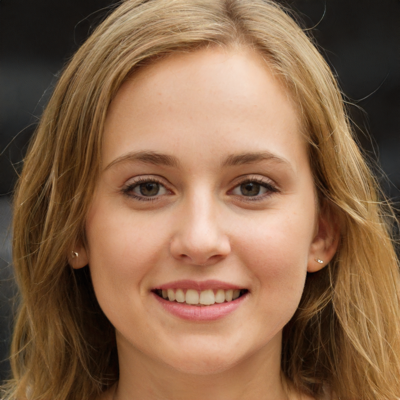

In [ ]:
images, latent_code2 = generate_image_random(9)
image2 = Image.fromarray(images[0]).resize((results_size, results_size))
latent_code2.shape
image2

In [ ]:
latent_code1[0][:5], latent_code2[0][:5]

(array([ 0.38708269,  0.54222439, -1.42507385, -0.96699115, -0.94480707]),
 array([ 1.10855471e-03, -2.89544069e-01, -1.11606630e+00, -1.28827567e-02,
        -3.78361464e-01]))

# **Interpolation entre les 2 latents spaces**

In [ ]:
def linear_interpolate(code1, code2, alpha):
    return code1 * alpha + code2 * (1 - alpha)

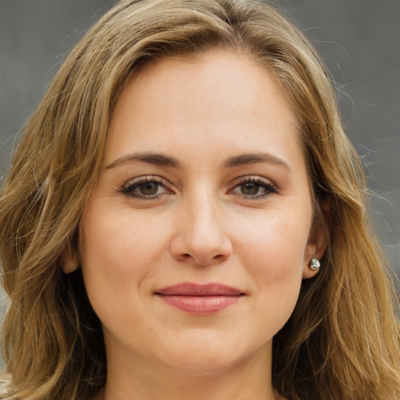

In [ ]:
interpolated_latent_code = linear_interpolate(latent_code1, latent_code2, 0.3)
interpolated_latent_code.shape
images = generate_image_from_z(interpolated_latent_code)
Image.fromarray(images[0]).resize((results_size, results_size))

In [ ]:
output_gifs_path = Path('output_gifs')
# Make Output Gifs folder if it doesn't exist.
if not output_gifs_path.exists():
    output_gifs_path.mkdir()

In [ ]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def make_latent_interp_animation(code1, code2, img1, img2, num_interps):
    
    step_size = 1.0/num_interps
    
    all_imgs = []
    
    amounts = np.arange(0, 1, step_size)
    
    for alpha in tqdm(amounts):
        interpolated_latent_code = linear_interpolate(code1, code2, alpha)
        images = generate_image_from_z(interpolated_latent_code)
        interp_latent_image = Image.fromarray(images[0]).resize((400, 400))
        frame = get_concat_h(img1, interp_latent_image)
        frame = get_concat_h(frame, img2)
        all_imgs.append(frame)

    save_name = output_gifs_path/'latent_space_traversal.gif'
    all_imgs[0].save(save_name, save_all=True, append_images=all_imgs[1:], duration=1000/fps, loop=0)

In [ ]:
make_latent_interp_animation(latent_code1, latent_code2, image1, image2, num_interps=500)

# **Importation des images** 


In [ ]:
orig_img_path = Path('imgs')
aligned_imgs_path = Path('aligned_imgs')

# Make Aligned Images folder if it doesn't exist.
if not aligned_imgs_path.exists():
    aligned_imgs_path.mkdir()
if not orig_img_path.exists():
    orig_img_path.mkdir()


orig_img_path, aligned_imgs_path

(PosixPath('imgs'), PosixPath('aligned_imgs'))

In [ ]:
if not Path('shape_predictor_68_face_landmarks.dat').exists():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dv shape_predictor_68_face_landmarks.dat.bz2

--2021-12-14 22:54:46--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  73.6MB/s    in 0.8s    

2021-12-14 22:54:47 (73.6 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

  shape_predictor_68_face_landmarks.dat.bz2: done


In [ ]:
"""
brief: face alignment with FFHQ method (https://github.com/NVlabs/ffhq-dataset)
author: lzhbrian (https://lzhbrian.me)
date: 2020.1.5
note: code is heavily borrowed from 
    https://github.com/NVlabs/ffhq-dataset
    http://dlib.net/face_landmark_detection.py.html
requirements:
    apt install cmake
    conda install Pillow numpy scipy
    pip install dlib
    # download face landmark model from: 
    # http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
"""

import numpy as np
import PIL
import PIL.Image
import sys
import os
import glob
import scipy
import scipy.ndimage
import dlib


# download model from: http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')

def get_landmark(filepath):
    """get landmark with dlib
    :return: np.array shape=(68, 2)
    """
    detector = dlib.get_frontal_face_detector()
    print(filepath)
    img = dlib.load_rgb_image(filepath)
    dets = detector(img, 1)

    print("Number of faces detected: {}".format(len(dets)))
    for k, d in enumerate(dets):
        print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
            k, d.left(), d.top(), d.right(), d.bottom()))
        # Get the landmarks/parts for the face in box d.
        shape = predictor(img, d)
        print("Part 0: {}, Part 1: {} ...".format(shape.part(0), shape.part(1)))


    t = list(shape.parts())
    a = []
    for tt in t:
        a.append([tt.x, tt.y])
    lm = np.array(a)
    # lm is a shape=(68,2) np.array
    return lm

    
def align_face(filepath):
    """
    :param filepath: str
    :return: PIL Image
    """
    lm = get_landmark(filepath)
    
    lm_chin          = lm[0  : 17]  # left-right
    lm_eyebrow_left  = lm[17 : 22]  # left-right
    lm_eyebrow_right = lm[22 : 27]  # left-right
    lm_nose          = lm[27 : 31]  # top-down
    lm_nostrils      = lm[31 : 36]  # top-down
    lm_eye_left      = lm[36 : 42]  # left-clockwise
    lm_eye_right     = lm[42 : 48]  # left-clockwise
    lm_mouth_outer   = lm[48 : 60]  # left-clockwise
    lm_mouth_inner   = lm[60 : 68]  # left-clockwise

    # Calculate auxiliary vectors.
    eye_left     = np.mean(lm_eye_left, axis=0)
    eye_right    = np.mean(lm_eye_right, axis=0)
    eye_avg      = (eye_left + eye_right) * 0.5
    eye_to_eye   = eye_right - eye_left
    mouth_left   = lm_mouth_outer[0]
    mouth_right  = lm_mouth_outer[6]
    mouth_avg    = (mouth_left + mouth_right) * 0.5
    eye_to_mouth = mouth_avg - eye_avg

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    y = np.flipud(x) * [-1, 1]
    c = eye_avg + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    qsize = np.hypot(*x) * 2


    # read image
    img = PIL.Image.open(filepath)

    output_size=1024
    transform_size=4096
    enable_padding=True

    # Shrink.
    shrink = int(np.floor(qsize / output_size * 0.5))
    if shrink > 1:
        rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
        img = img.resize(rsize, PIL.Image.ANTIALIAS)
        quad /= shrink
        qsize /= shrink

    # Crop.
    border = max(int(np.rint(qsize * 0.1)), 3)
    crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]), min(crop[3] + border, img.size[1]))
    if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
        img = img.crop(crop)
        quad -= crop[0:2]

    # Pad.
    pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
    if enable_padding and max(pad) > border - 4:
        pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
        img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
        h, w, _ = img.shape
        y, x, _ = np.ogrid[:h, :w, :1]
        mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w-1-x) / pad[2]), 1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h-1-y) / pad[3]))
        blur = qsize * 0.02
        img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
        img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
        img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
        quad += pad[:2]

    # Transform.
    img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
    if output_size < transform_size:
        img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS)

    # Save aligned image.

    return img

# **Pre-Processing the images**

In [ ]:
# Align all of our images using a landmark detection model!
all_imgs = list(orig_img_path.iterdir())
for img in all_imgs:
    align_face(str(img)).save(aligned_imgs_path/('aligned_'+img.name))

In [ ]:
# Align all of our images using a landmark detection model!
#all_imgs = list(orig_img_path.iterdir())
#all_imgs = [('imgs/ALF.jpg'),('imgs/JDO.jpg')]
#align_face(str('imgs/ALF.jpeg')).save("img_ALF.jpg","JPEG")
#align_face(str('imgs/JDO.jpeg')).save("img_JDO.jpg","JPEG")


# **Projecting our own Input Images into the Latent Space**

In [ ]:
!python -W ignore stylegan2/dataset_tool.py create_from_images datasets_stylegan2/custom_imgs aligned_imgs/

Loading images from "aligned_imgs/"
Creating dataset "datasets_stylegan2/custom_imgs"
Added 2 images.


In [ ]:
tot_aligned_imgs = 2

In [ ]:
!python -W ignore stylegan2/epoching_custom_run_projector.py project-real-images --network=$model_path \
  --dataset=custom_imgs --data-dir=datasets_stylegan2 --num-images=$tot_aligned_imgs --num-snapshots 1000

Local submit - run_dir: results/00000-project-real-images
dnnlib: Running run_projector.project_real_images() on localhost...
Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.
Loading images from "custom_imgs"...
tcmalloc: large alloc 4294967296 bytes == 0x5576f4280000 @  0x7fb6d24bc001 0x7fb6d003a54f 0x7fb6d008ab58 0x7fb6d008eb17 0x7fb6d012d203 0x5576a4e18544 0x5576a4e18240 0x5576a4e8c627 0x5576a4e86ced 0x5576a4e1a48c 0x5576a4e5b159 0x5576a4e580a4 0x5576a4e1a698 0x5576a4e88fe4 0x5576a4e869ee 0x5576a4e19bda 0x5576a4e88737 0x5576a4e869ee 0x5576a4d58e2b 0x5576a4e88fe4 0x5576a4e19afa 0x5576a4e87915 0x5576a4e19afa 0x5576a4e87c0d 0x5576a4e869ee 0x5576a4d58e2b 0x5576a4e88fe4 0x5576a4e19afa 0x5576a4e87915 0x5576a4e869ee 0x5576a4e866f3
tcmalloc: large alloc 4294967296 bytes == 0x5577f42

In [ ]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def make_project_progress_gifs():
    
    all_result_folders = list(Path('results/').iterdir())
    all_result_folders.sort()

    last_result_folder = all_result_folders[-1]
    
    for img_num in range(tot_aligned_imgs):
        all_step_pngs = [x for x in last_result_folder.iterdir() if x.name.endswith('png') and 'image{0:04d}'.format(img_num) in x.name]
        all_step_pngs.sort()

        target_image = Image.open(all_step_pngs[-1]).resize((results_size, results_size))

        all_concat_imgs = []
        for step_img_path in all_step_pngs[:-1]:
            step_img = Image.open(step_img_path).resize((results_size, results_size))
            all_concat_imgs.append(get_concat_h(target_image, step_img))

        all_concat_imgs[0].save('output_gifs/image{0:04d}_project_progress.gif'.format(img_num), save_all=True, append_images=all_concat_imgs[1:], duration=1000/fps, loop=0)

In [ ]:
output_gifs_path = Path('output_gifs')
# Make Output Gifs folder if it doesn't exist.
if not output_gifs_path.exists():
    output_gifs_path.mkdir()
make_project_progress_gifs()

# **Recuperer les code latents extraits des images**

In [ ]:
def get_final_latents():
    all_results = list(Path('results/').iterdir())
    all_results.sort()

    last_result = all_results[-1]
    print("last_result is :",last_result)

    latent_files = [x for x in last_result.iterdir() if 'final_latent_code' in x.name]
    print("latent_files is :",latent_files)
    latent_files.sort()
    all_final_latents = []
    
    for file in latent_files:
        with open(file, mode='rb') as latent_pickle:
            all_final_latents.append(pickle.load(latent_pickle))
    
    return all_final_latents

In [ ]:
latent_codes = get_final_latents()
len(latent_codes), latent_codes[0].shape, latent_codes[1].shape


In [ ]:
from google.colab import files
files.download('results/00000-project-real-images/image0000-final_latent_code.pkl')
files.download('results/00000-project-real-images/image0001-final_latent_code.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Interpolation entre les 2 espace latents recrées**

In [ ]:
def load_model():
    _G, _D, Gs = pretrained_networks.load_networks(model_path)
    
    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
    
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    
    return Gs, noise_vars, Gs_kwargs

def generate_image_from_projected_latents(latent_vector):
    images = Gs.components.synthesis.run(latent_vector, **Gs_kwargs)
    return images

In [ ]:
Gs, noise_vars, Gs_kwargs = load_model()

In [ ]:
output_gifs_path = Path('output_gifs/')
aligned_imgs_path = Path('aligned_imgs/')
aligned_img_set = list(aligned_imgs_path.iterdir())
aligned_img_set.sort()
aligned_img_set = [Image.open(x) for x in aligned_img_set]

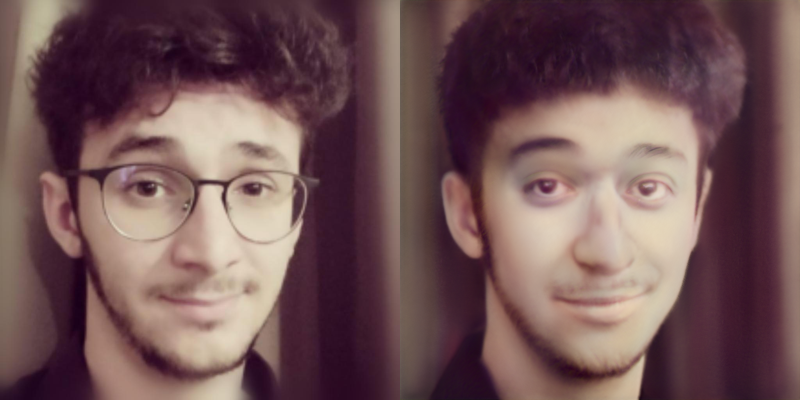

In [ ]:
images = generate_image_from_projected_latents(latent_codes[0])
recreated_img1 = Image.fromarray(images[0]).resize((results_size, results_size))

orig_img1 = aligned_img_set[1].resize((results_size, results_size))
get_concat_h(orig_img1, recreated_img1)

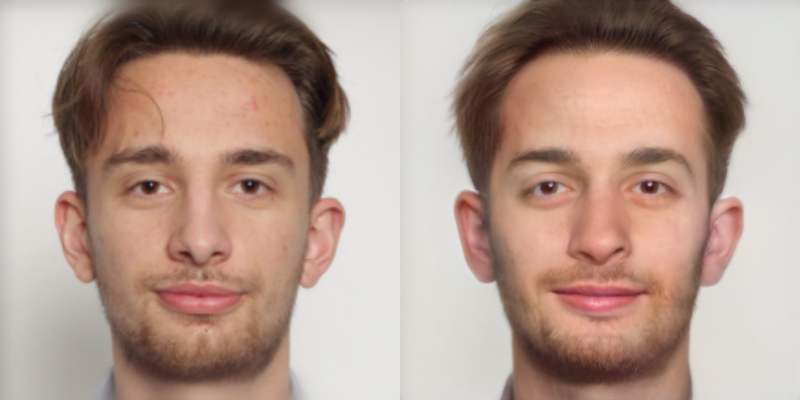

In [ ]:
images = generate_image_from_projected_latents(latent_codes[1])
recreated_img2 = Image.fromarray(images[0]).resize((results_size, results_size))

orig_img2 = aligned_img_set[0].resize((results_size, results_size))
get_concat_h(orig_img2, recreated_img2)

In [ ]:
def linear_interpolate(code1, code2, alpha):
    return code1 * alpha + code2 * (1 - alpha)

def make_latent_interp_animation_real_faces(code1, code2, img1, img2, num_interps):
    
    step_size = 1.0/num_interps
    
    all_imgs = []
    
    amounts = np.arange(0, 1, step_size)
    
    for alpha in tqdm(amounts):
        interpolated_latent_code = linear_interpolate(code1, code2, alpha)
        images = generate_image_from_projected_latents(interpolated_latent_code)
        interp_latent_image = Image.fromarray(images[0]).resize((400, 400))
        frame = get_concat_h(img2, interp_latent_image)
        frame = get_concat_h(frame, img1)
        all_imgs.append(frame)

    save_name = output_gifs_path/'projected_latent_space_traversal.gif'
    all_imgs[0].save(save_name, save_all=True, append_images=all_imgs[1:], duration=1000/fps, loop=0)

In [ ]:
make_latent_interp_animation_real_faces(latent_codes[0], latent_codes[1], recreated_img1, recreated_img2, num_interps=200)

# **Exploration de l'espace Latent**

In [ ]:
def get_control_latent_vectors(path):
    files = [x for x in Path(path).iterdir() if str(x).endswith('.npy')]
    latent_vectors = {f.name[:-4]:np.load(f) for f in files}
    return latent_vectors

In [ ]:
latent_controls = get_control_latent_vectors('stylegan2directions/')
len(latent_controls), latent_controls.keys(), latent_controls['age'].shape

In [ ]:
def make_latent_control_animation(feature, start_amount, end_amount, step_size, person):
    
    all_imgs = []
    amounts = np.linspace(start_amount, end_amount, int(abs(end_amount-start_amount)/step_size))
    
    for amount_to_move in tqdm(amounts):
        modified_latent_code = np.array(latent_code_to_use)
        modified_latent_code += latent_controls[feature]*amount_to_move
        images = generate_image_from_projected_latents(modified_latent_code)
        latent_img = Image.fromarray(images[0]).resize((results_size, results_size))
        all_imgs.append(get_concat_h(image_to_use, latent_img))

    save_name = output_gifs_path/'{0}_{1}.gif'.format(person, feature)
    all_imgs[0].save(save_name, save_all=True, append_images=all_imgs[1:], duration=1000/fps, loop=0)

In [ ]:
import numpy as np
print(latent_code1.shape)
latent_code1 = np.repeat(latent_code1[np.newaxis,:], 18, 1)
print(latent_code1.shape)

(1, 512)
(1, 18, 512)


In [ ]:
latent_code_to_use = latent_code1
image_to_use = image1
make_latent_control_animation(feature='age', start_amount=-10, end_amount=10, step_size=0.1, person='Alf')

In [ ]:
latent_code_to_use = latent_codes[0]
image_to_use = recreated_img1
make_latent_control_animation(feature='age', start_amount=-5, end_amount=5, step_size=0.1, person='Jdo')

100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


In [ ]:
latent_code_to_use = latent_codes[1]
image_to_use = recreated_img2
make_latent_control_animation(feature='gender', start_amount=-10, end_amount=10, step_size=0.1, person='Alf')

100%|██████████| 200/200 [00:31<00:00,  6.33it/s]


In [ ]:
latent_code_to_use = latent_codes[0]
image_to_use = recreated_img1
make_latent_control_animation(feature='gender', start_amount=-10, end_amount=10, step_size=0.1, person='Jdo')

100%|██████████| 200/200 [00:31<00:00,  6.34it/s]


In [ ]:
def apply_latent_controls(self):
    
    image_outputs = controller.children[0]
    feature_sliders = controller.children[1]
    
    slider_hboxes = feature_sliders.children[:-2]
    latent_movements = [(x.children[1].value, x.children[0].value) for x in slider_hboxes]

    modified_latent_code = np.array(latent_code_to_use)
    for feature, amount_to_move in latent_movements:
        modified_latent_code += latent_controls[feature]*amount_to_move

    images = generate_image_from_projected_latents(modified_latent_code)
    latent_img = Image.fromarray(images[0]).resize((400, 400))
    
    latent_img_output = image_outputs.children[1]
    with latent_img_output:
        latent_img_output.clear_output()
        display(latent_img)

def reset_latent_controls(self):
    
    image_outputs = controller.children[0]
    feature_sliders = controller.children[1]
    
    slider_hboxes = feature_sliders.children[:-2]
    for x in slider_hboxes:
        x.children[0].value = 0
        
    latent_img_output = image_outputs.children[1]
    with latent_img_output:
        latent_img_output.clear_output()
        display(image_to_use)

def create_interactive_latent_controller():
    orig_img_output = widgets.Output()

    with orig_img_output:
        orig_img_output.clear_output()
        display(image_to_use)

    latent_img_output = widgets.Output()

    with latent_img_output:
        latent_img_output.clear_output()
        display(image_to_use)

    image_outputs = widgets.VBox([orig_img_output, latent_img_output])

    #collapse-hide
    generate_button = widgets.Button(description='Generate', layout=widgets.Layout(width='75%', height='10%'))
    generate_button.on_click(apply_latent_controls)

    reset_button = widgets.Button(description='Reset Latent Controls', layout=widgets.Layout(width='75%', height='10%'))
    reset_button.on_click(reset_latent_controls)

    feature_sliders = []
    for feature in latent_controls:
        label = widgets.Label(feature)
        slider = widgets.FloatSlider(min=-50, max=50)
        feature_sliders.append(widgets.HBox([slider, label]))
    feature_sliders.append(generate_button)
    feature_sliders.append(reset_button)
    feature_sliders = widgets.VBox(feature_sliders)

    return widgets.HBox([image_outputs, feature_sliders])

In [ ]:
latent_codes[1].shape

(1, 18, 512)

In [ ]:
latent_code_to_use = latent_code1
image_to_use = image1

controller = create_interactive_latent_controller()
controller